<a href="https://colab.research.google.com/github/lherron2/thermomaps-ising/blob/main/Ising_TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone repo
%cd /content/
!rm -rf thermomaps-ising
!git clone https://github.com/lherron2/thermomaps-ising.git

# Install repo
%cd /content/thermomaps-ising/thermomaps-root/
!pip install -e .
!pip install einops

/content
Cloning into 'thermomaps-ising'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 267 (delta 1), reused 0 (delta 0), pack-reused 265
Receiving objects: 100% (267/267), 64.98 KiB | 1.91 MiB/s, done.
Resolving deltas: 100% (142/142), done.
/content/thermomaps-ising/thermomaps-root
Obtaining file:///content/thermomaps-ising/thermomaps-root
  Preparing metadata (setup.py) ... done
  Running setup.py develop for thermomaps
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 542.2 kB/s eta 0:00:00


In [2]:
import os
import ising
import numpy as np
import matplotlib.pyplot as plt

from ising.swedsen_wang_simulator import IsingSwendsenWang, Energy, Magnetization

from tm.core.Backbone import ConvBackbone
from tm.core.DiffusionModel import DiffusionTrainer, SteeredDiffusionSampler
from tm.core.DiffusionProcesses import VPDiffusion
from tm.core.Loader import Loader
from tm.core.Prior import GlobalEquilibriumHarmonicPrior
from tm.core.utils import compute_model_dim

from tm.architectures.UNet2D_mid_attn import Unet2D


In [59]:
class IsingArgs:
  size = 8
  warm_up = 1000
  steps = 5000
  temp = 2
  Jx = 1
  Jy = 1
  sampling_frequency = 5
  filename = "ising"

In [84]:
dataset, paired_temperatures, trajectory_dict, trajectory_fluctuation_dict = [], [], {}, {}
temperatures = [1,1.5,2,2.5,3]

# Generating data at three temperatures using Swedsen-Wang sampling
for sim_idx, temp in enumerate(temperatures):

  observables = [Energy(Jx = IsingArgs.Jx, Jy = IsingArgs.Jy), Magnetization()]

  # Initialize simulation
  sim = IsingSwendsenWang(size = IsingArgs.size, warm_up = IsingArgs.warm_up,
                          temp = temp, Jx = IsingArgs.Jx, Jy = IsingArgs.Jy)

  # Run simulation
  results = sim.simulate(steps = IsingArgs.steps, observables = observables,
                         sampling_frequency = IsingArgs.sampling_frequency)

  # Coordinates are lattice configurations
  coordinates = np.expand_dims(results['lattice'], 1)

  # Fluctuations are temperatures (coordinates are sampled from the global equilibrium distribution)
  fluctuations = np.ones_like(coordinates) * temp

  # Form the TM input data by joining coordinates and fluctuations along the channel axis
  data = np.concatenate((coordinates, fluctuations), axis=1)

  dataset.append(data)

  # Each coordinate trajectory was collected at a temperature and has associated fluctuations
  # (include sim_idx in case there are repeat temperatures)
  trajectory_fluctuation_dict[f"{temp}_{sim_idx}"] = fluctuations
  trajectory_dict[f"{temp}_{sim_idx}"] = coordinates

  # Each coordinate frame is paired with a temperature
  temps_arr = np.ones(len(coordinates)) * temp
  paired_temperatures.append(temps_arr)

dataset = np.concatenate(dataset)
paired_temperatures = np.concatenate(paired_temperatures)

The inputs to the `Loader` are the dataset and the temperatures associated with each sample, and control parameters. The control axis is the axis of the data containing the data that is to be controlled. For example, the default of `control_axis = 1` indicates that the control parameters may be retrieved along the channel dimension of the data, assuming the data is of shape `(n_samples, n_channels, x, y)`. In the provided example there are two channels: one containing lattice configurations and another containing the temperatures. Since the temperatures are the second dimension along the `control_axis`, we set `control_dims=(1,2)`. This way, the temperatures can be retrieved using a `loader.control_slice` via `loader.data[loader.control_slice]`.





In [61]:
loader = Loader(data = dataset, temperatures = paired_temperatures,
                control_axis = 1, control_dims = (1,2))

The `GlobalEquilibriumHarmonicPrior` (`GEHP`) is responsible for sampling the prior at the correct temperature. The inputs to the `GEHP` is a dictionary `trajectory_fluctuation_dict` containing key-value pairs of generated coordinate trajectories, and the temperatures that the trajectories were generated at.

In [62]:
GEHP = GlobalEquilibriumHarmonicPrior(data=trajectory_fluctuation_dict)

The format required as input for the `GEHP` might seem convoluted, but that is because there is also a `LocalEquilibriumHarmonicPrior` (`LEHP`) that performs the computations associated with fluctuation mapping. This involves computing fluctuations over each trajectory in the input dictionary, and fitting a multi-linear function to the (temperatures, fluctuation) data.

Next we initialize the black-box `model(nn.Module)` that will be parameterized during training. In this case, the `model` is a 2D U-net with attention at the bottleneck layer.

In [63]:
# get model dim that is compatible w/ data shape + possible model shapes.
model_dim = compute_model_dim(loader.data_dim, groups=8)
model = Unet2D(
    dim=model_dim,
    dim_mults=(1, 2, 2, 4), # downsampling/upsampling factors before/after bottleneck
    resnet_block_groups=8,
    self_condition=True, # greatly improves training convergence when data is limited
    learned_sinusoidal_cond=True,
    channels=2, # two channels for Ising model data
)

The `backbone` is a wrapper class around `model` that contains methods used to load and save models, and automatically upsamples image-structured data to match the dimensions of the model.

In [64]:
backbone = ConvBackbone(
    model=model,
    data_shape=loader.data_dim,
    target_shape=model_dim, # data is upsampled to this resolution
    num_dims=4, # (n_sample, n_channel, n_x, n_y)
    lr=1e-3,
    eval_mode="train",
    self_condition=True,
    )

The `VPDiffusion` class contains methods to evaluate forward and reverse diffusion kernels for the Variance Preserving diffusion process described in Song (2019).

In [65]:
diffusion = VPDiffusion(num_diffusion_timesteps=100)

A `DiffusionTrainer` trains a `backbone` model to reverse the diffusion process (`VPDiffusion`) applied to coordinates (`dataset` in `Loader`). Optionally, the model can be trained to predict the original samples directly (`pred_type=x0`) or the noise used to corrupt the sample (`pred_type=noise`).

In [119]:
trainer = DiffusionTrainer(diffusion, backbone, loader, model_dir='/content/TM/models',
                           pred_type='x0', prior=GEHP, device='cuda:0')
trainer.train(50, loss_type="l2", batch_size=8, print_freq=100)

step: 0, loss 5.869
step: 100, loss 5.017
step: 200, loss 4.832
step: 300, loss 5.655
step: 400, loss 7.517
step: 500, loss 7.041
step: 600, loss 7.353
epoch: 29
step: 0, loss 6.545
step: 100, loss 5.822
step: 200, loss 6.808
step: 300, loss 6.434
step: 400, loss 8.182
step: 500, loss 6.187
step: 600, loss 7.103
epoch: 30
step: 0, loss 5.984
step: 100, loss 6.832
step: 200, loss 7.298
step: 300, loss 4.628
step: 400, loss 7.853
step: 500, loss 4.405
step: 600, loss 7.971
epoch: 31
step: 0, loss 3.950
step: 100, loss 8.469
step: 200, loss 6.581
step: 300, loss 6.832
step: 400, loss 5.866
step: 500, loss 4.965
step: 600, loss 6.913
epoch: 32
step: 0, loss 5.078
step: 100, loss 4.933
step: 200, loss 5.322
step: 300, loss 7.133
step: 400, loss 21.003
step: 500, loss 7.359
step: 600, loss 4.921
epoch: 33
step: 0, loss 9.652
step: 100, loss 6.833
step: 200, loss 4.912
step: 300, loss 4.580
step: 400, loss 8.509
step: 500, loss 60.551
step: 600, loss 3.205
epoch: 34
step: 0, loss 7.210
step: 

KeyboardInterrupt: ignored

Now sample from the thermodynamic map using the `SteeredDiffusionSampler`. First load the model corresponding to the epoch that you want to sample from, and then pass the `DiffusionProcess`, `Loader`, and `Prior` used to train the model. Optionally, provide a scalar `gamma` that conditions over the fluctuations during the generative process when `gamma=1`. Otherwise, if `gamma=0` the conditional process is carried out for the fluctuations dimensions.

In [138]:
for T in np.linspace(1,3,10):
  backbone.load_model('/content/TM/models', epoch=40, device='cuda:0')

  sampler = SteeredDiffusionSampler(diffusion_process=diffusion, backbone=backbone,
                                    loader=loader, sample_dir='/content/TM/samples',
                                    pred_type='x0', prior=GEHP, gamma=1)

  sampler.sample_loop(num_samples=1000, batch_size=1000, save_prefix='ising',
                      temperature=np.round(T,2), n_ch=2)


In [139]:
def recursive_scandir(path):
    with os.scandir(path) as it:
        for entry in it:
            yield entry  # Yield the current entry
            if entry.is_dir():  # If the entry is a directory, recurse into it
                yield from recursive_scandir(entry.path)

In [140]:
mag_dict = {}
for f in recursive_scandir('/content/TM/samples/'):
  if f.is_file() and f.name.endswith('npz'):
    temp = float(os.path.basename(os.path.dirname(f.path))[:-1])
    npz = np.load(f.path)
    samples = npz['traj'].squeeze()
    samples[samples > 0] = 1
    samples[samples < 0] = -1
    mag_dict[temp] = np.array([abs(Magnetization().evaluate(s)) for s in samples]).mean()

sim_mag_dict = {}
for k, series in trajectory_dict.items():
  k = float(k.split('_')[0])
  sim_mag_dict[k] = np.array([abs(Magnetization().evaluate(s)) for s in series]).mean()

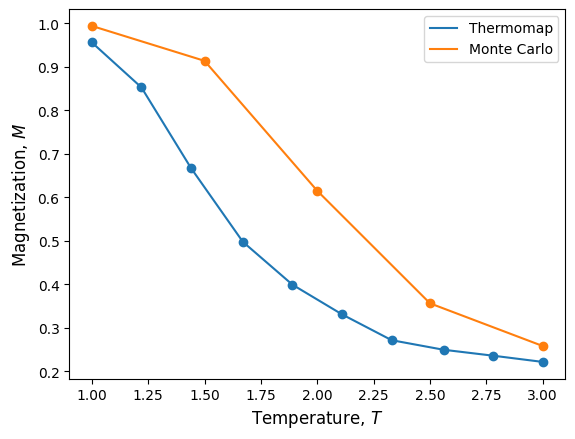

In [141]:
idxs = np.argsort(list(mag_dict.keys()))
x = np.array(list(mag_dict.keys()))[idxs]
y = np.array(list(mag_dict.values()))[idxs]
plt.scatter(x, y)
plt.plot(x,y, label="Thermomap")

idxs = np.argsort(list(sim_mag_dict.keys()))
x = np.array(list(sim_mag_dict.keys()))[idxs]
y = np.array(list(sim_mag_dict.values()))[idxs]
plt.scatter(x, y)
plt.plot(x,y, label="Monte Carlo")
plt.xlabel("Temperature, $T$", fontsize=12)
plt.ylabel("Magnetization, $M$", fontsize=12)
plt.legend()

(1000, 8, 8)

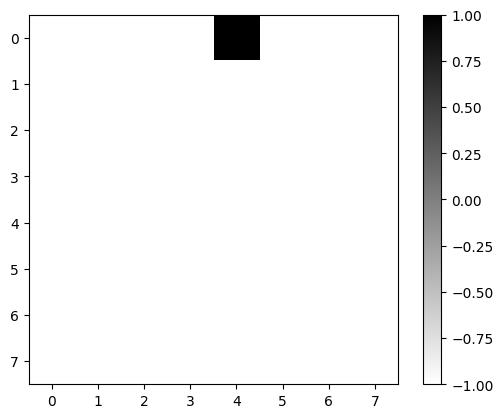

In [137]:
npz = np.load("/content/TM/samples/1.0K/ising_idx=0.npz")
samples = npz['traj'].squeeze()
frame = samples[6]
frame[frame > 0] = 1
frame[frame < 0] = -1
plt.imshow(frame, cmap='binary')
plt.colorbar()